# Studying MLP architectures with the MNIST dataset

In [1]:
# Packages which are not installed in the SageMaker TF2 kernel
!pip install matplotlib --quiet

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os

### tf2.x
import tensorflow as tf
from tensorflow import keras

### Data prep
from sklearn.model_selection import train_test_split

### Model evaluation
from sklearn.metrics import classification_report

In [3]:
# Some common settings
pd.set_option('max_columns', None)
pd.set_option('max_rows', 100)

# Global random state
np.random.seed(42)
tf.random.set_seed(42)

# Some common variables
PATH_DATA = "./datasets"
PATH_CHECKPOINT = './checkpoints'
root_logdir ='s3://tensor.board/logs'

In [4]:
# Custom functions
def reset_keras():
    keras.backend.clear_session()
    
def get_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

## Get the dataset

In [5]:
# Read the data into _raw np array
train_raw = np.loadtxt(f'{PATH_DATA}/train.csv', skiprows=1, delimiter=',')
X_test_raw = np.loadtxt(f'{PATH_DATA}/test.csv', skiprows=1, delimiter=',')

# Check the shape
print(train_raw.shape, X_test_raw.shape)

(42000, 785) (28000, 784)


In [6]:
# Training set
X = train_raw[:, 1:].copy()
y = train_raw[:, 0].copy()  # first column is label

# Test set
X_test = X_test_raw.copy()

# Check the shape
print(X.shape, y.shape, X_test.shape)

(42000, 784) (42000,) (28000, 784)


## EDA

<hr>

**Summary:** This MNIST dataset contains 42000 hand-written digits, with each a 28x28 (=784) dimension array. There is no class imbalance, nor contains any missing values.

<hr>

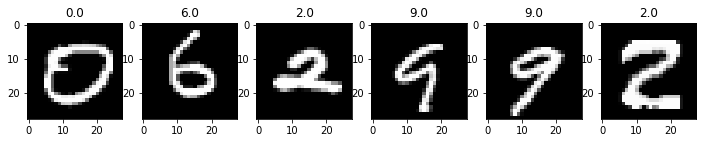

In [7]:
# Print some randomly selected digits
size = 6

fig, axes = plt.subplots(1, size, figsize=(12, 12))
for i, j in enumerate(np.random.randint(0, X.shape[0], size)):
    plt.subplot(1, size, i+1)
    plt.title(y[j])
    plt.imshow(X[j].reshape(28, 28), cmap="gray")

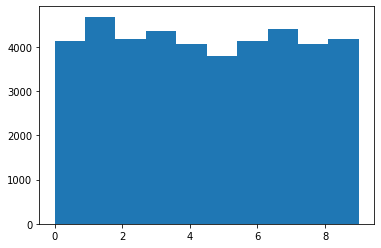

In [8]:
# How's the label distribution
plt.hist(y, bins=10)
plt.show()

In [9]:
# Any missing values?
print("Missing values in training set:", np.isnan(X).sum())
print("Missing values in test set:", np.isnan(X_test).sum())

Missing values in training set: 0
Missing values in test set: 0


## Data processing

In [10]:
# Spliting into training and validation set
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=.2, random_state=42)

# Check the shape
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(33600, 784) (8400, 784) (33600,) (8400,)


In [11]:
# Scaling to between 0-1
X_train = X_train/255
X_valid = X_valid/255
X_test = X_test/255

## Research design

<hr>

**Summary:** We will conduct a 2x2 factorial design to test the effect of numer of hidden layer and neurons of a multilayer perceptron (MLP) on the model training time and performance (accuracy), using the MNIST dataset.

* Experiment A: 1 hidden layer, 50 neurons
* Experiment B: 1 hidden layer, 100 neurons
* Experiment C: 2 hidden layers, 50 neurons each
* Experiment D: 2 hidden layers, 100 neurons each

<hr>

### Experiment A: 1 hidden layer, 50 neurons

In [12]:
# Build the model
model = keras.models.Sequential([
    keras.layers.Dense(50, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(10, activation="softmax")
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                39250     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                510       
Total params: 39,760
Trainable params: 39,760
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Compile the model
model.compile(loss="sparse_categorical_crossentropy",    # y is not one hot encoded
              optimizer=keras.optimizers.SGD(lr=0.01),   # default lr
              metrics=["accuracy"])                      # Kaggle evaluates with accuracy and not AUC

In [14]:
# Callbacks
checkpoint_cb = keras.callbacks.ModelCheckpoint(f'{PATH_CHECKPOINT}/mnist_A.h5',
                                                save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(get_logdir(), update_freq='epoch')

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)

In [15]:
%%time

# Fit the model
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Train on 33600 samples, validate on 8400 samples
Epoch 1/100
33600/33600 [==============================] - 2s 69us/sample - loss: 0.9053 - accuracy: 0.7705 - val_loss: 0.4912 - val_accuracy: 0.8730
Epoch 2/100
33600/33600 [==============================] - 2s 58us/sample - loss: 0.4160 - accuracy: 0.8885 - val_loss: 0.3817 - val_accuracy: 0.8932
Epoch 3/100
33600/33600 [==============================] - 2s 58us/sample - loss: 0.3471 - accuracy: 0.9046 - val_loss: 0.3403 - val_accuracy: 0.9046
Epoch 4/100
33600/33600 [==============================] - 2s 58us/sample - loss: 0.3126 - accuracy: 0.9129 - val_loss: 0.3169 - val_accuracy: 0.9107
Epoch 5/100
33600/33600 [==============================] - 2s 58us/sample - loss: 0.2897 - accuracy: 0.9194 - val_loss: 0.2994 - val_accuracy: 0.9144
Epoch 6/100
33600/33600 [==============================] - 2s 58us/sample - loss: 0.2722 - accuracy: 0.9241 - val_loss: 0.2833 - val_accuracy: 0.9189
Epoch 7/100
33600/33600 [==========================

#### Evaluate

In [16]:
# Performance on the validation set
y_pred = model.predict_classes(X_valid)

print(classification_report(y_valid, y_pred, digits=5))

              precision    recall  f1-score   support

         0.0    0.98164   0.98284   0.98224       816
         1.0    0.98136   0.98460   0.98298       909
         2.0    0.97006   0.95745   0.96371       846
         3.0    0.96360   0.96051   0.96205       937
         4.0    0.96407   0.95948   0.96177       839
         5.0    0.96264   0.95442   0.95851       702
         6.0    0.96612   0.98089   0.97345       785
         7.0    0.95175   0.97200   0.96177       893
         8.0    0.95793   0.95449   0.95621       835
         9.0    0.95060   0.94153   0.94604       838

    accuracy                        0.96500      8400
   macro avg    0.96498   0.96482   0.96487      8400
weighted avg    0.96501   0.96500   0.96498      8400



#### Predict

In [17]:
# Predict the classes
y_test = model.predict_classes(X_test)

# Prepare file for submission
submission = pd.DataFrame({'ImageId': list(range(1, 28001, 1)),
                           'Label': y_test})
submission.to_csv(f'{PATH_DATA}/submission_A.csv', index=False)

### Experiment B: 1 hidden layer, 100 neurons

In [18]:
# Build the model
model = keras.models.Sequential([
    keras.layers.Dense(100, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(10, activation="softmax")
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Compile the model
model.compile(loss="sparse_categorical_crossentropy",    # y is not one hot encoded
              optimizer=keras.optimizers.SGD(lr=0.01),   # default lr
              metrics=["accuracy"])                      # Kaggle evaluates with accuracy and not AUC

In [20]:
# Callbacks
checkpoint_cb = keras.callbacks.ModelCheckpoint(f'{PATH_CHECKPOINT}/mnist_B.h5',
                                                save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(get_logdir(), update_freq='epoch')

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)

In [21]:
%%time

# Fit the model
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Train on 33600 samples, validate on 8400 samples
Epoch 1/100
33600/33600 [==============================] - 2s 63us/sample - loss: 0.8111 - accuracy: 0.8003 - val_loss: 0.4642 - val_accuracy: 0.8776
Epoch 2/100
33600/33600 [==============================] - 2s 61us/sample - loss: 0.4007 - accuracy: 0.8904 - val_loss: 0.3720 - val_accuracy: 0.8983
Epoch 3/100
33600/33600 [==============================] - 2s 58us/sample - loss: 0.3411 - accuracy: 0.9043 - val_loss: 0.3341 - val_accuracy: 0.9068
Epoch 4/100
33600/33600 [==============================] - 2s 57us/sample - loss: 0.3094 - accuracy: 0.9135 - val_loss: 0.3127 - val_accuracy: 0.9118
Epoch 5/100
33600/33600 [==============================] - 2s 59us/sample - loss: 0.2869 - accuracy: 0.9192 - val_loss: 0.2949 - val_accuracy: 0.9160
Epoch 6/100
33600/33600 [==============================] - 2s 57us/sample - loss: 0.2691 - accuracy: 0.9245 - val_loss: 0.2785 - val_accuracy: 0.9221
Epoch 7/100
33600/33600 [==========================

#### Evaluate

In [22]:
# Performance on the validation set
y_pred = model.predict_classes(X_valid)

print(classification_report(y_valid, y_pred, digits=5))

              precision    recall  f1-score   support

         0.0    0.97802   0.98162   0.97982       816
         1.0    0.98142   0.98790   0.98465       909
         2.0    0.97365   0.96099   0.96728       846
         3.0    0.96459   0.95945   0.96201       937
         4.0    0.97020   0.97020   0.97020       839
         5.0    0.96532   0.95157   0.95839       702
         6.0    0.97233   0.98471   0.97848       785
         7.0    0.96875   0.97200   0.97037       893
         8.0    0.96420   0.96766   0.96593       835
         9.0    0.96067   0.96181   0.96124       838

    accuracy                        0.97000      8400
   macro avg    0.96992   0.96979   0.96984      8400
weighted avg    0.96999   0.97000   0.96998      8400



#### Predict

In [23]:
# Predict the classes
y_test = model.predict_classes(X_test)

# Prepare file for submission
submission = pd.DataFrame({'ImageId': list(range(1, 28001, 1)),
                           'Label': y_test})
submission.to_csv(f'{PATH_DATA}/submission_B.csv', index=False)

### Experiment C: 2 hidden layers, 50 neurons each

In [24]:
# Build the model
model = keras.models.Sequential([
    keras.layers.Dense(50, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 50)                39250     
_________________________________________________________________
dense_5 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_6 (Dense)              (None, 10)                510       
Total params: 42,310
Trainable params: 42,310
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Compile the model
model.compile(loss="sparse_categorical_crossentropy",    # y is not one hot encoded
              optimizer=keras.optimizers.SGD(lr=0.01),   # default lr
              metrics=["accuracy"])                      # Kaggle evaluates with accuracy and not AUC

In [26]:
# Callbacks
checkpoint_cb = keras.callbacks.ModelCheckpoint(f'{PATH_CHECKPOINT}/mnist_C.h5',
                                                save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(get_logdir(), update_freq='epoch')

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)

In [27]:
%%time

# Fit the model
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Train on 33600 samples, validate on 8400 samples
Epoch 1/100
33600/33600 [==============================] - 2s 68us/sample - loss: 1.0083 - accuracy: 0.7191 - val_loss: 0.4700 - val_accuracy: 0.8702
Epoch 2/100
33600/33600 [==============================] - 2s 60us/sample - loss: 0.3917 - accuracy: 0.8874 - val_loss: 0.3539 - val_accuracy: 0.8974
Epoch 3/100
33600/33600 [==============================] - 2s 61us/sample - loss: 0.3193 - accuracy: 0.9071 - val_loss: 0.3089 - val_accuracy: 0.9096
Epoch 4/100
33600/33600 [==============================] - 2s 61us/sample - loss: 0.2802 - accuracy: 0.9190 - val_loss: 0.2836 - val_accuracy: 0.9158
Epoch 5/100
33600/33600 [==============================] - 2s 60us/sample - loss: 0.2521 - accuracy: 0.9258 - val_loss: 0.2622 - val_accuracy: 0.9235
Epoch 6/100
33600/33600 [==============================] - 2s 62us/sample - loss: 0.2303 - accuracy: 0.9318 - val_loss: 0.2407 - val_accuracy: 0.9292
Epoch 7/100
33600/33600 [==========================

#### Evaluate

In [28]:
# Performance on the validation set
y_pred = model.predict_classes(X_valid)

print(classification_report(y_valid, y_pred, digits=5))

              precision    recall  f1-score   support

         0.0    0.98037   0.97917   0.97977       816
         1.0    0.97819   0.98680   0.98248       909
         2.0    0.97708   0.95745   0.96716       846
         3.0    0.95931   0.95624   0.95778       937
         4.0    0.96770   0.96424   0.96597       839
         5.0    0.95184   0.95726   0.95455       702
         6.0    0.97100   0.98089   0.97592       785
         7.0    0.97062   0.96193   0.96625       893
         8.0    0.96364   0.95210   0.95783       835
         9.0    0.93953   0.96420   0.95171       838

    accuracy                        0.96607      8400
   macro avg    0.96593   0.96603   0.96594      8400
weighted avg    0.96616   0.96607   0.96608      8400



#### Predict

In [29]:
# Predict the classes
y_test = model.predict_classes(X_test)

# Prepare file for submission
submission = pd.DataFrame({'ImageId': list(range(1, 28001, 1)),
                           'Label': y_test})
submission.to_csv(f'{PATH_DATA}/submission_C.csv', index=False)

### Experiment D: 2 hidden layers, 100 neurons each

In [30]:
# Build the model
model = keras.models.Sequential([
    keras.layers.Dense(100, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_8 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_9 (Dense)              (None, 10)                1010      
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
_________________________________________________________________


In [31]:
# Compile the model
model.compile(loss="sparse_categorical_crossentropy",    # y is not one hot encoded
              optimizer=keras.optimizers.SGD(lr=0.01),   # default lr
              metrics=["accuracy"])                      # Kaggle evaluates with accuracy and not AUC

In [32]:
# Callbacks
checkpoint_cb = keras.callbacks.ModelCheckpoint(f'{PATH_CHECKPOINT}/mnist_D.h5',
                                                save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(get_logdir(), update_freq='epoch')

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)

In [33]:
%%time

# Fit the model
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Train on 33600 samples, validate on 8400 samples
Epoch 1/100
33600/33600 [==============================] - 2s 67us/sample - loss: 0.8873 - accuracy: 0.7716 - val_loss: 0.4250 - val_accuracy: 0.8826
Epoch 2/100
33600/33600 [==============================] - 2s 60us/sample - loss: 0.3566 - accuracy: 0.8987 - val_loss: 0.3319 - val_accuracy: 0.9060
Epoch 3/100
33600/33600 [==============================] - 2s 60us/sample - loss: 0.2977 - accuracy: 0.9138 - val_loss: 0.2925 - val_accuracy: 0.9177
Epoch 4/100
33600/33600 [==============================] - 2s 60us/sample - loss: 0.2637 - accuracy: 0.9247 - val_loss: 0.2703 - val_accuracy: 0.9227
Epoch 5/100
33600/33600 [==============================] - 2s 61us/sample - loss: 0.2373 - accuracy: 0.9325 - val_loss: 0.2477 - val_accuracy: 0.9288
Epoch 6/100
33600/33600 [==============================] - 2s 62us/sample - loss: 0.2163 - accuracy: 0.9381 - val_loss: 0.2270 - val_accuracy: 0.9370
Epoch 7/100
33600/33600 [==========================

#### Evaluate

In [35]:
# Performance on the validation set
y_pred = model.predict_classes(X_valid)

print(classification_report(y_valid, y_pred, digits=5))

              precision    recall  f1-score   support

         0.0    0.98765   0.98039   0.98401       816
         1.0    0.97831   0.99230   0.98525       909
         2.0    0.96471   0.96927   0.96698       846
         3.0    0.95860   0.96371   0.96115       937
         4.0    0.96782   0.96782   0.96782       839
         5.0    0.96006   0.95869   0.95937       702
         6.0    0.97695   0.97197   0.97446       785
         7.0    0.97395   0.96305   0.96847       893
         8.0    0.96723   0.95449   0.96082       835
         9.0    0.94811   0.95943   0.95374       838

    accuracy                        0.96833      8400
   macro avg    0.96834   0.96811   0.96821      8400
weighted avg    0.96837   0.96833   0.96833      8400



#### Predict

In [36]:
# Predict the classes
y_test = model.predict_classes(X_test)

# Prepare file for submission
submission = pd.DataFrame({'ImageId': list(range(1, 28001, 1)),
                           'Label': y_test})
submission.to_csv(f'{PATH_DATA}/submission_D.csv', index=False)

## Look at some wrongly recognized digits

Digit 9 and 5 have the lowest F1-score. Notice that some of the images are hard to recognize even by human.

In [37]:
def show_wrong_digits(X_valid, y_valid, y_pred, digit):
    # Show 6 images
    size = 6
    # Get the indices where the model made a wrong prediction for the specified digit
    idx = np.where((y_pred != digit) & (y_valid == digit))
    
    # Show the images and predicted labels
    fig, axes = plt.subplots(1, size, figsize=(12, 12))
    for i, j in enumerate(np.random.choice(idx[0], size, replace=False)):
        plt.subplot(1, size, i+1)
        plt.title(y_pred[j])
        # Transform back into the original scale
        plt.imshow((X_valid[j]*255).reshape(28, 28), cmap="gray")

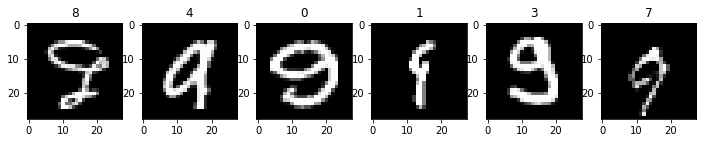

In [38]:
# Show some wrongly recognized digit 9
show_wrong_digits(X_valid, y_valid, y_pred, 9)

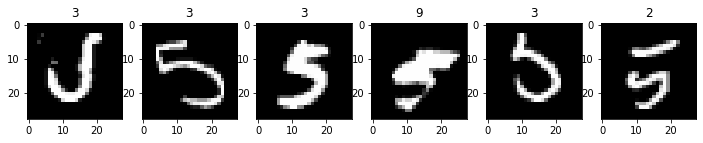

In [39]:
# Show some wrongly recognized digit 5
show_wrong_digits(X_valid, y_valid, y_pred, 5)

## Conclusion

<hr>

| Experiment | Number of hidden layers | Number of neurons per layer | Model fitting time (s) | Validation set accuracy | Test set accuracy |
| --- | --- | --- | --- | --- | --- |
| A | 1 | 50 | 194 | 0.9650 | 0.96342 |
| B | 1 | 100 | 194 | 0.9700 | 0.96871 |
| C | 2 | 50 | 123 | 0.9661 | 0.9650 |
| D | 2 | 100 | 104 | 0.9683 | 0.96671 |

**Summary:** Experiment A has the simplest MLP architecture (1 hidden layer x 50 neurons) with 39760 parameters to train. Note that this model didn't converge quickly, and the fitting time is long (run all 100 epochs). In experiment B we have doubled the neurons in the hidden layer, making this model much more parameters (79510) to train. Note that this model also didn't converge quickly with long fitting time (run all 100 epochs).

In experiment C, we have built the model with 2 hidden layers (50 neurons each) with 42310 parameters to train. Note that this model converges quicker and the early stopping callback kicks in. Thus we can fit the model in a shorter time. In experiment D, we have a 2 hidden layer model (100 neurons each) with 89610 parameters to train. This model converges quickly and we can stop the fitting the earliest.

It seems reasonable to build a model with more layers and neurons than needed, and use early stopping technique to interupt model fitting. With modern hardware (this experiment was run on a machine with Nvidia T4 GPU), we generally can get a good performing model in a shorter time. To test this approach, we built a significantly more complex model with 3 hidden layers (500 menrons each), and the result looks promising.

| Experiment | Number of hidden layers | Number of neurons per layer | Model fitting time (s) | Validation set accuracy | Test set accuracy |
| --- | --- | --- | --- | --- | --- |
| Final | 3 | 500 | 121 | 0.9726 | 0.97014 |


<hr>

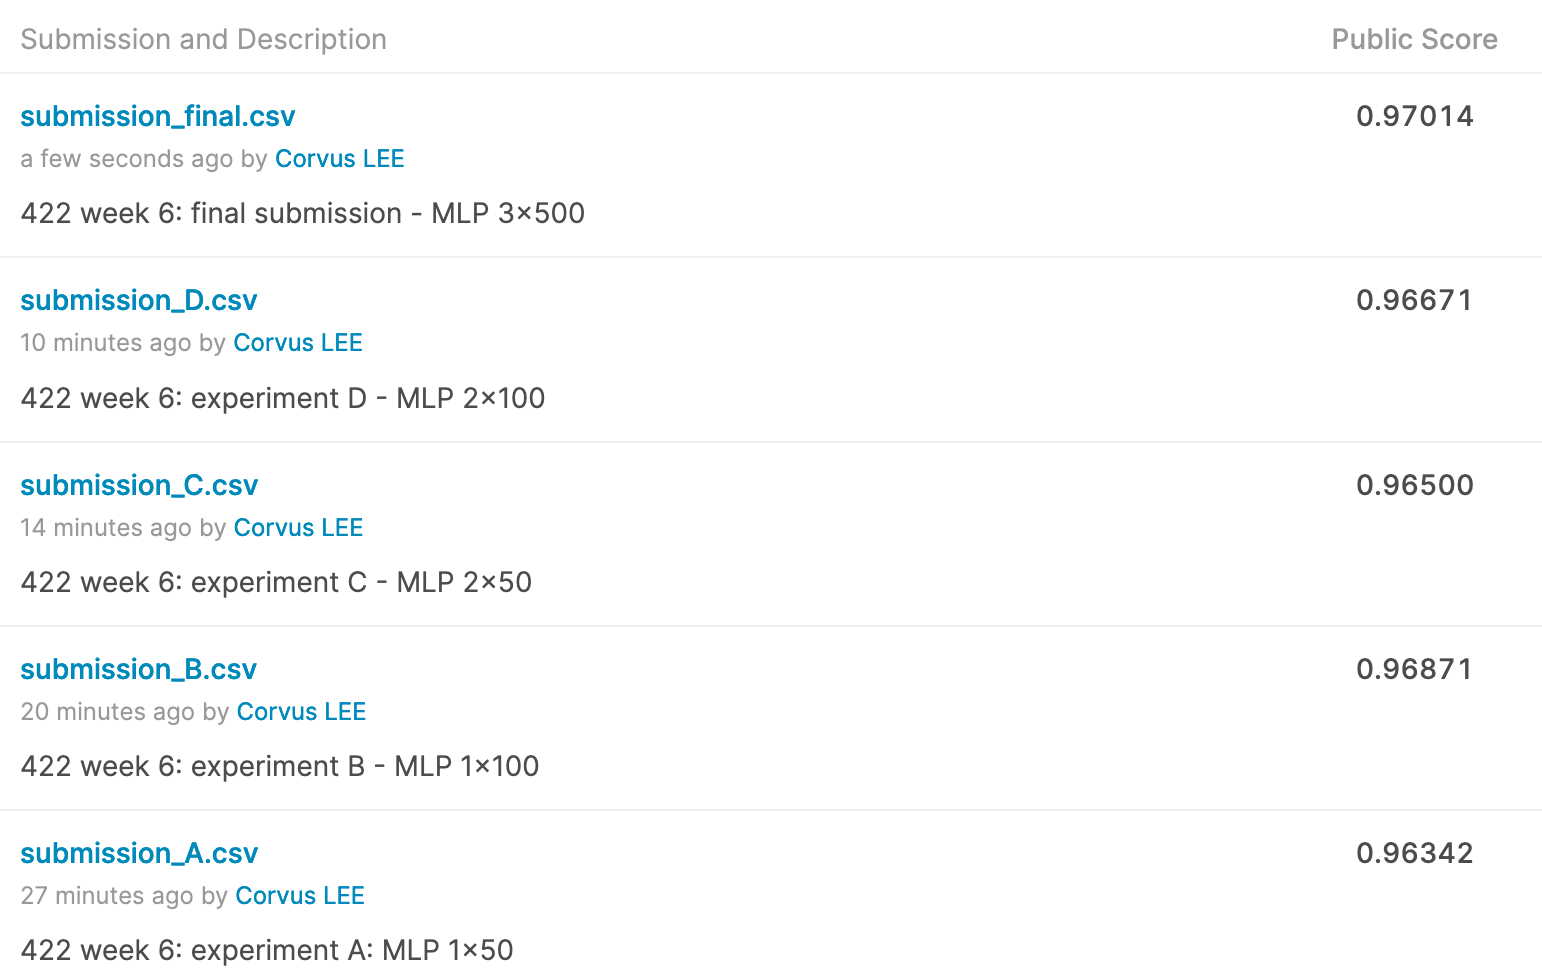

### Final: 3 hidden layers, 500 neurons each

In [40]:
# Build the model
model = keras.models.Sequential([
    keras.layers.Dense(500, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(500, activation="relu"),
    keras.layers.Dense(500, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 500)               392500    
_________________________________________________________________
dense_11 (Dense)             (None, 500)               250500    
_________________________________________________________________
dense_12 (Dense)             (None, 500)               250500    
_________________________________________________________________
dense_13 (Dense)             (None, 10)                5010      
Total params: 898,510
Trainable params: 898,510
Non-trainable params: 0
_________________________________________________________________


In [41]:
# Compile the model
model.compile(loss="sparse_categorical_crossentropy",    # y is not one hot encoded
              optimizer=keras.optimizers.SGD(lr=0.01),   # default lr
              metrics=["accuracy"])                      # Kaggle evaluates with accuracy and not AUC

In [42]:
# Callbacks
checkpoint_cb = keras.callbacks.ModelCheckpoint(f'{PATH_CHECKPOINT}/mnist_D.h5',
                                                save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(get_logdir(), update_freq='epoch')

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)

In [43]:
%%time

# Fit the model
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb, early_stopping_cb])

Train on 33600 samples, validate on 8400 samples
Epoch 1/100
   32/33600 [..............................] - ETA: 3:00 - loss: 2.3399 - accuracy: 0.0625WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.264881). Check your callbacks.


33600/33600 [==============================] - 4s 121us/sample - loss: 0.7687 - accuracy: 0.8115 - val_loss: 0.3663 - val_accuracy: 0.8937
Epoch 2/100
33600/33600 [==============================] - 3s 91us/sample - loss: 0.2982 - accuracy: 0.9127 - val_loss: 0.2796 - val_accuracy: 0.9205
Epoch 3/100
33600/33600 [==============================] - 3s 87us/sample - loss: 0.2412 - accuracy: 0.9300 - val_loss: 0.2324 - val_accuracy: 0.9337
Epoch 4/100
33600/33600 [==============================] - 3s 88us/sample - loss: 0.2041 - accuracy: 0.9422 - val_loss: 0.2148 - val_accuracy: 0.9381
Epoch 5/100
33600/33600 [==============================] - 3s 89us/sample - loss: 0.1762 - accuracy: 0.9491 - val_loss: 0.1889 - val_accuracy: 0.9444
Epoch 6/100
33600/33600 [==============================] - 3s 87us/sample - loss: 0.1554 - accuracy: 0.9556 - val_loss: 0.1701 - val_accuracy: 0.9512
Epoch 7/100
33600/33600 [==============================] - 3s 95us/sample - loss: 0.1376 - accuracy: 0.9606 - v

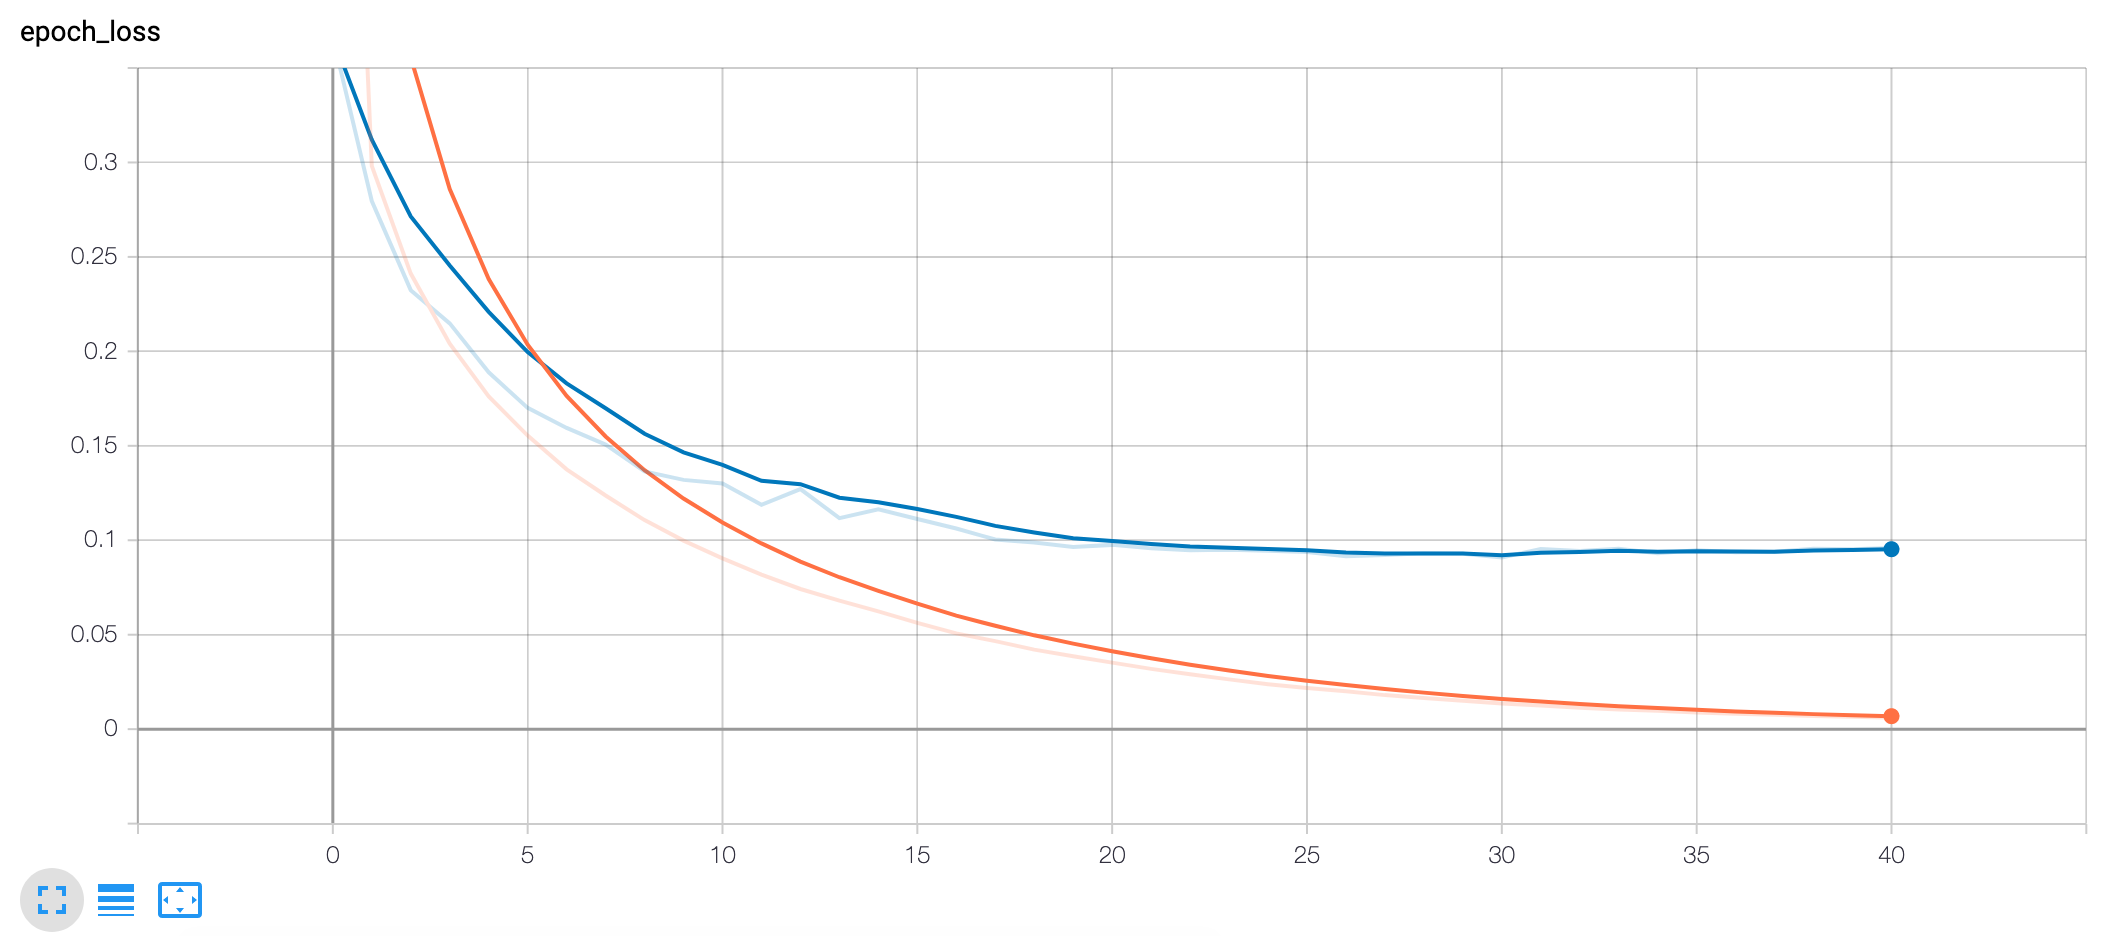

### Evaluate

In [44]:
# Performance on the validation set
y_pred = model.predict_classes(X_valid)

print(classification_report(y_valid, y_pred, digits=5))

              precision    recall  f1-score   support

         0.0    0.98289   0.98529   0.98409       816
         1.0    0.97516   0.99340   0.98420       909
         2.0    0.97494   0.96572   0.97031       846
         3.0    0.97097   0.96371   0.96733       937
         4.0    0.97272   0.97735   0.97503       839
         5.0    0.96143   0.95869   0.96006       702
         6.0    0.97848   0.98471   0.98159       785
         7.0    0.97654   0.97872   0.97763       893
         8.0    0.96731   0.95689   0.96207       835
         9.0    0.96403   0.95943   0.96172       838

    accuracy                        0.97262      8400
   macro avg    0.97245   0.97239   0.97240      8400
weighted avg    0.97260   0.97262   0.97259      8400



### Predict

In [45]:
# Predict the classes
y_test = model.predict_classes(X_test)

# Prepare file for submission
submission = pd.DataFrame({'ImageId': list(range(1, 28001, 1)),
                           'Label': y_test})
submission.to_csv(f'{PATH_DATA}/submission_final.csv', index=False)